$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Task 2

In [29]:
%matplotlib notebook
from openquantumcomputing.QAOABase import QAOABase
from openquantumcomputing.utilities import decompose
from openquantumcomputing.mixer_utilities import get_T, get_Pauli_string_with_algorithm3, simplifyH, get_g
from new_functions import *
from qiskit import Aer, QuantumRegister, ClassicalRegister, QuantumCircuit, visualization
from sympy.physics.paulialgebra import Pauli
from sympy.physics.quantum import TensorProduct
from sympy import symbols, Add, Mul, Symbol, core
from matplotlib import pyplot as plt
import time
import itertools

In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [3]:
def plot_hist(qaoa, angles, params = {}):
    fig = plt.figure(figsize = (9.5, 5))
    hist = qaoa.hist(
        angles = angles, backend = qasmSim, shots = 10000, params = params)
    plt.bar(range(len(hist)), 
            np.array(list(hist.values())) / 10000., 
            tick_label = [key[::-1] for key in list(hist.keys())])
    plt.xlabel("state"); plt.ylabel("probability"); plt.xticks(rotation=85)
    fig.show()

In [4]:
qasmSim = Aer.get_backend("qasm_simulator") 

## Example 1

### hard-coded circuit 

Feasible subspace: $ B = \{\ket{100}, \ket{010}, \ket{011}\} $

$$H_{mixer} = \frac{1}{2}(XXI + XXZ + IIX + ZIX + XXX - XYY)$$

$$ H_{cost} \ket{\psi} = 1, \forall \psi \in B $$
$$ H_{cost} \ket{\psi} = 20, \forall \psi \notin B $$

In [5]:
feasible_states = np.array(["100", "010", "011"])

# decompose H_cost into pauli string
H_cost = 20. * np.ones(2 ** 3)
for feasible_state in feasible_states:
    H_cost[int(feasible_state, 2)] = 1.
H_cost = pauli_string_to_sympy(np.diag(H_cost))
display(H_cost)

dim= 3.0


c*(12.875*1x1x1 - 2.375*1x1xsigma3 + 2.375*1xsigma3x1 - 2.375*1xsigma3xsigma3 - 2.375*sigma3x1x1 + 2.375*sigma3x1xsigma3 + 7.125*sigma3xsigma3x1 + 2.375*sigma3xsigma3xsigma3)

In [6]:
class QAOA_example1_hard_coded(QAOABase):
    def cost(self, string, params):
        if string in ["100", "010", "011"]:
            return 1.
        return 20.

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        # initial state
        ampl = 1. / np.sqrt(3.)
        ampl_vec = [0., 0., ampl, ampl, ampl, 0., 0., 0.]
        circ.initialize(ampl_vec, [q[2], q[1], q[0]])
        circ.barrier()
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # cost hamiltonian
            # -IIZ
            circ.rz(-2. * gamma * -19. / 8., q[2])
            circ.barrier()
            
            # IZI
            circ.rz(-2. * gamma * 19. / 8., q[1])
            circ.barrier()
            
            # -IZZ
            circ.cx(q[1], q[2])
            circ.rz(-2. * gamma * -19. / 8., q[2])
            circ.cx(q[1], q[2])
            circ.barrier()
   
            # -ZII
            circ.rz(-2. * gamma * -19. / 8., q[0])
            circ.barrier()
        
            # ZIZ
            circ.cx(q[0], q[2])
            circ.rz(-2. * gamma * 19. / 8., q[2])
            circ.cx(q[0], q[2])
            circ.barrier()
            
            # ZZI
            circ.cx(q[0], q[1])
            circ.rz(-2. * gamma * 57. / 8., q[1])
            circ.cx(q[0], q[1])
            circ.barrier()
            
            # ZZZ
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * gamma * 19. / 8., q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.barrier()
        
            # mixer hamiltonian
            # XXI
            circ.h([q[0], q[1]])
            circ.cx(q[0], q[1])
            circ.rz(-2. * beta * 0.5, q[1])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1]])
            circ.barrier()
            
            # XXZ
            circ.h([q[0], q[1]])
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1]])
            circ.barrier()

            # IIX
            circ.h(q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.h(q[2])
            circ.barrier()

            # ZIX
            circ.h(q[2])
            circ.cx(q[0], q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.cx(q[0], q[2])
            circ.h(q[2])
            circ.barrier()
            
            # XXX
            circ.h([q[0], q[1], q[2]])
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1], q[2]])
            circ.barrier()
            
            # -XYY
            circ.s([q[1], q[2]])
            circ.h([q[0], q[1], q[2]])
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * beta * -0.5, q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1], q[2]])
            circ.sdg([q[1], q[2]])
            circ.barrier()
        
        circ.measure(q, c)
        return circ

display(QAOA_example1_hard_coded().createCircuit([1.0, 1.0], 1).draw())

┌────────────────────────────────────────────────┐ ░              ░ »
q0_0: ┤2                                               ├─░──────────────░─»
      │                                                │ ░              ░ »
q0_1: ┤1 Initialize(0,0,0.57735,0.57735,0.57735,0,0,0) ├─░──────────────░─»
      │                                                │ ░ ┌──────────┐ ░ »
q0_2: ┤0                                               ├─░─┤ Rz(4.75) ├─░─»
      └────────────────────────────────────────────────┘ ░ └──────────┘ ░ »
c0: 3/════════════════════════════════════════════════════════════════════»
                                                                          »
«                    ░                        ░ ┌──────────┐ ░      »
«q0_0: ──────────────░────────────────────────░─┤ Rz(4.75) ├─░───■──»
«      ┌───────────┐ ░                        ░ └──────────┘ ░   │  »
«q0_1: ┤ Rz(-4.75) ├─░───■────────────────■───░──────────────░───┼──»
«      └───────────┘ ░ ┌─┴─┐┌──────────┐┌─┴─┐ ░              ░ ┌─┴─┐»
«q0_2: ──────────────░─┤ X ├┤ Rz(4.75) ├┤ X ├─░──────────────░─┤ X ├»
«                    ░ └───┘└──────────┘└───┘ ░              ░ └───┘»
«c0: 3/═════════════════════════════════════════════════════════════»
«                                                                   »
«                         ░                          ░                        »
«q0_0: ───────────────■───░───■──────────────────■───░───■────────────────────»
«                     │   ░ ┌─┴─┐┌────────────┐┌─┴─┐ ░ ┌─┴─┐                  »
«q0_1: ───────────────┼───░─┤ X ├┤ Rz(-14.25) ├┤ X ├─░─┤ X ├──■───────────────»
«      ┌───────────┐┌─┴─┐ ░ └───┘└────────────┘└───┘ ░ └───┘┌─┴─┐┌───────────┐»
«q0_2: ┤ Rz(-4.75) ├┤ X ├─░──────────────────────────░──────┤ X ├┤ Rz(-4.75) ├»
«      └───────────┘└───┘ ░                          ░      └───┘└───────────┘»
«c0: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«                 ░ ┌───┐                    ┌───┐ ░ ┌───┐                    »
«q0_0: ───────■───░─┤ H ├──■──────────────■──┤ H ├─░─┤ H ├──■─────────────────»
«           ┌─┴─┐ ░ ├───┤┌─┴─┐┌────────┐┌─┴─┐├───┤ ░ ├───┤┌─┴─┐               »
«q0_1: ──■──┤ X ├─░─┤ H ├┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├─░─┤ H ├┤ X ├──■────────────»
«      ┌─┴─┐└───┘ ░ └───┘└───┘└────────┘└───┘└───┘ ░ └───┘└───┘┌─┴─┐┌────────┐»
«q0_2: ┤ X ├──────░────────────────────────────────░───────────┤ X ├┤ Rz(-1) ├»
«      └───┘      ░                                ░           └───┘└────────┘»
«c0: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«                ┌───┐ ░                      ░                               »
«q0_0: ───────■──┤ H ├─░──────────────────────░────────■──────────────■───────»
«           ┌─┴─┐├───┤ ░                      ░        │              │       »
«q0_1: ──■──┤ X ├┤ H ├─░──────────────────────░────────┼──────────────┼───────»
«      ┌─┴─┐└───┘└───┘ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌─┴─┐┌────────┐┌─┴─┐┌───┐»
«q0_2: ┤ X ├───────────░─┤ H ├┤ Rz(-1) ├┤ H ├─░─┤ H ├┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├»
«      └───┘           ░ └───┘└────────┘└───┘ ░ └───┘└───┘└────────┘└───┘└───┘»
«c0: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«       ░ ┌───┐                              ┌───┐ ░ ┌───┐               »
«q0_0: ─░─┤ H ├──■────────────────────────■──┤ H ├─░─┤ H ├───────■───────»
«       ░ ├───┤┌─┴─┐                    ┌─┴─┐├───┤ ░ ├───┤┌───┐┌─┴─┐     »
«q0_1: ─░─┤ H ├┤ X ├──■──────────────■──┤ X ├┤ H ├─░─┤ S ├┤ H ├┤ X ├──■──»
«       ░ ├───┤└───┘┌─┴─┐┌────────┐┌─┴─┐├───┤└───┘ ░ ├───┤├───┤└───┘┌─┴─┐»
«q0_2: ─░─┤ H ├─────┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├──────░─┤ S ├┤ H ├─────┤ X ├»
«       ░ └───┘     └───┘└────────┘└───┘└───┘      ░ └───┘└───┘     └───┘»
«c0: 3/

In [7]:
qaoa_example1_hard_coded = QAOA_example1_hard_coded()
qaoa_example1_hard_coded.increase_depth(backend = qasmSim, precision = 0.25)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -1.0


<IPython.core.display.Javascript object>


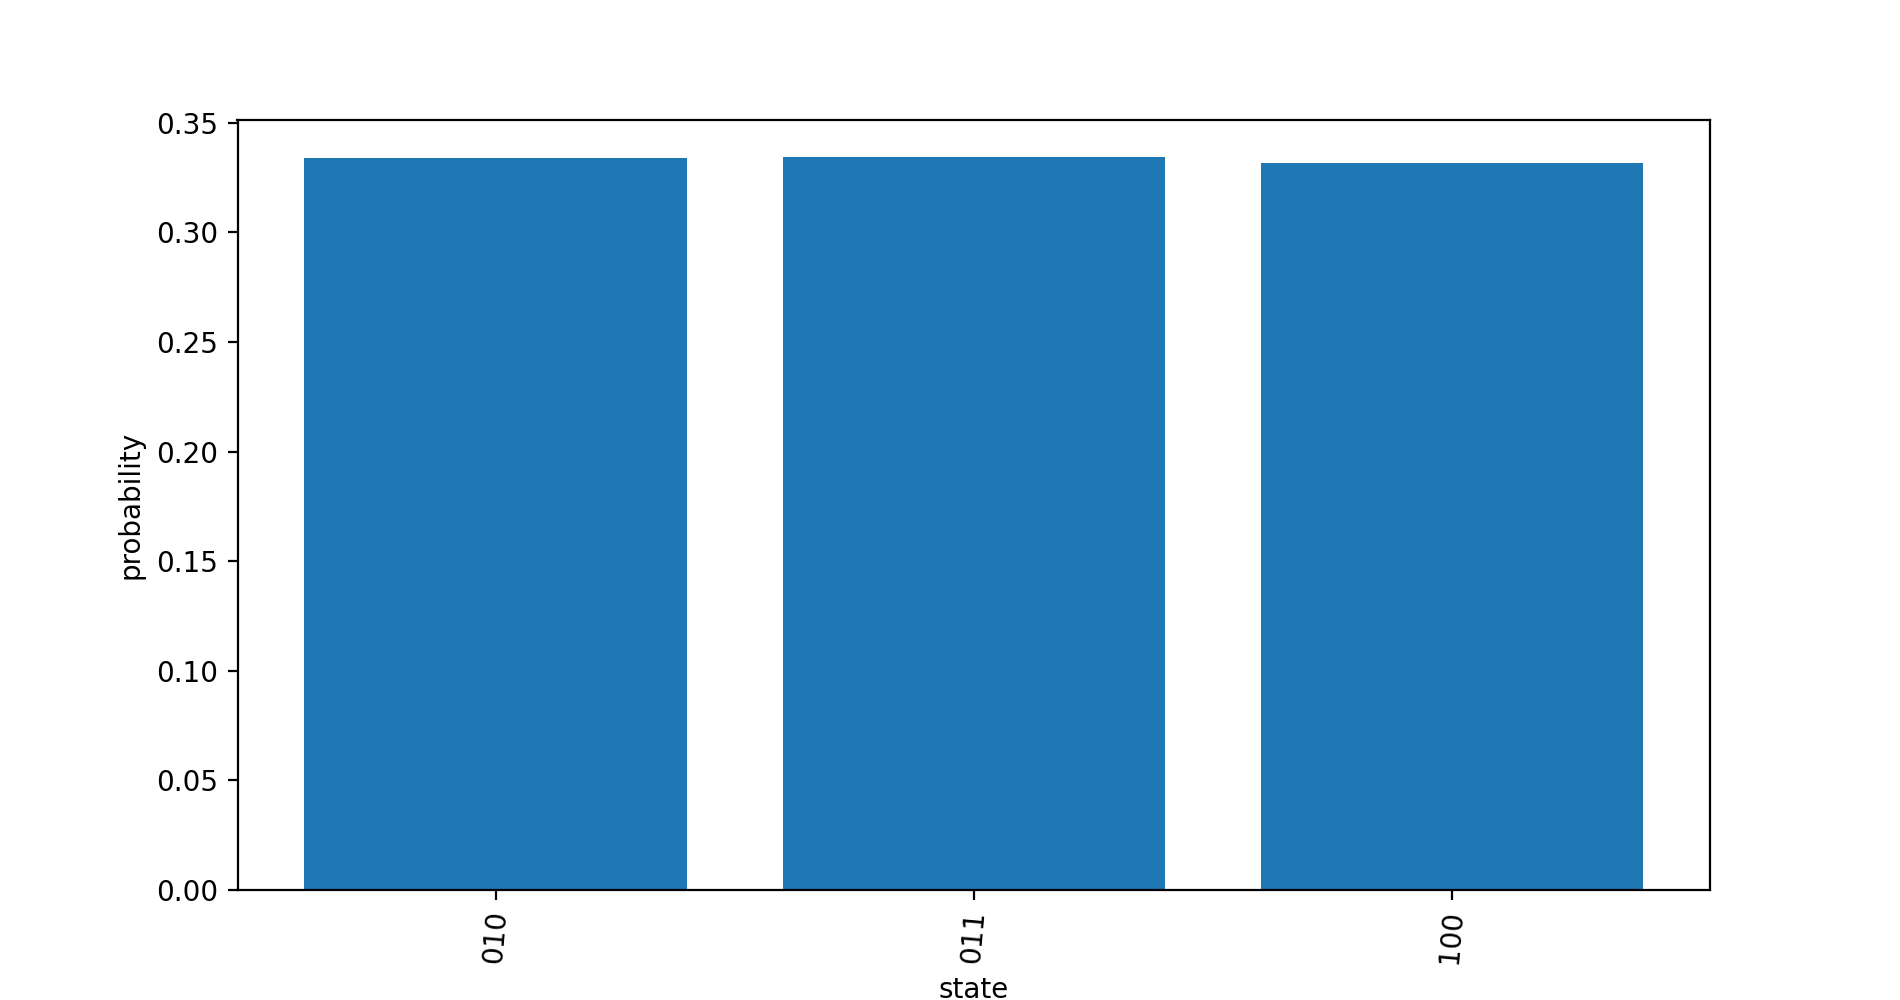

In [8]:
plot_hist(qaoa_example1_hard_coded, qaoa_example1_hard_coded.angles_hist["d1_final"])

### Circuit from algorithms

In [9]:
# create mixer from algorithm 3
table = {
    (0, 1) : np.array(["000", "110"]),
    (1, 2) : np.array(["000", "001"]),
    (2, 0) : np.array(["000", "111"])}

H_mixer = 0
T_c = get_T(2, "nearest_int")
for index, ((i, j), mix_states) in enumerate(table.items()):
    T_ij = get_T(3, "leftright", i = i, j = j)
    H_b_ij = get_Pauli_string_with_algorithm3(feasible_states, T_ij)
    H_c_ij = get_Pauli_string_with_algorithm3(mix_states, T_c)
    c = symbols(f"c{index}", commutative = False)
    H_mixer += c * simplifyH(H_b_ij + H_c_ij)
display(H_mixer)

c0*(0.5*sigma1xsigma1x1 + 0.5*sigma1xsigma1xsigma3) + c1*(0.5*1x1xsigma1 + 0.5*sigma3x1xsigma1) + c2*(0.5*sigma1xsigma1xsigma1 - 0.5*sigma1xsigma2xsigma2)

In [10]:
params1 = {"H_cost_array" : create_circuit_array(H_cost),
           "H_mixer_array" : create_circuit_array(H_mixer)}

In [11]:
class QAOA_example1_with_algorithms(QAOABase):
    def cost(self, string, params):
        if string in ["100", "010", "011"]:
            return 1.
        return 20.

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        # initial state
        ampl = 1. / np.sqrt(3.)
        ampl_vec = [0., 0., ampl, ampl, ampl, 0., 0., 0.]
        circ.initialize(ampl_vec, q[::-1])
        circ.barrier()
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            create_circuit_from_array(circ, params.get("H_cost_array"), gamma)
            
            # H_mixer
            create_circuit_from_array(circ, params.get("H_mixer_array"), beta)
            
        circ.measure(q, c)
        return circ

display(QAOA_example1_with_algorithms().createCircuit(
    [1.0, 1.0], 1, params = params1).draw())

┌────────────────────────────────────────────────┐ ░               ░ »
q11419_0: ┤2                                               ├─░───────────────░─»
          │                                                │ ░ ┌───────────┐ ░ »
q11419_1: ┤1 Initialize(0,0,0.57735,0.57735,0.57735,0,0,0) ├─░─┤ Rz(-4.75) ├─░─»
          │                                                │ ░ └───────────┘ ░ »
q11419_2: ┤0                                               ├─░───────────────░─»
          └────────────────────────────────────────────────┘ ░               ░ »
  c415: 3/═════════════════════════════════════════════════════════════════════»
                                                                               »
«                                  ░                                   ░      »
«q11419_0: ──■─────────────────■───░───■───────────────────────────■───░───■──»
«            │                 │   ░ ┌─┴─┐                       ┌─┴─┐ ░ ┌─┴─┐»
«q11419_1: ──┼─────────────────┼───░─┤ X ├──■─────────────────■──┤ X ├─░─┤ X ├»
«          ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘ ░ └───┘»
«q11419_2: ┤ X ├┤ Rz(-4.75) ├┤ X ├─░──────┤ X ├┤ Rz(-4.75) ├┤ X ├──────░──────»
«          └───┘└───────────┘└───┘ ░      └───┘└───────────┘└───┘      ░      »
«  c415: 3/═══════════════════════════════════════════════════════════════════»
«                                                                             »
«                              ░  ░              ░                        ░ »
«q11419_0: ────────────────■───░──░──────────────░────────────────────────░─»
«          ┌────────────┐┌─┴─┐ ░  ░              ░                        ░ »
«q11419_1: ┤ Rz(-14.25) ├┤ X ├─░──░──────────────░───■────────────────■───░─»
«          └────────────┘└───┘ ░  ░ ┌──────────┐ ░ ┌─┴─┐┌──────────┐┌─┴─┐ ░ »
«q11419_2: ────────────────────░──░─┤ Rz(4.75) ├─░─┤ X ├┤ Rz(4.75) ├┤ X ├─░─»
«                              ░  ░ └──────────┘ ░ └───┘└──────────┘└───┘ ░ »
«  c415: 3/═════════════════════════════════════════════════════════════════»
«                                                                           »
«          ┌──────────┐ ░ ┌───┐                    ┌───┐ ░ ┌───┐          »
«q11419_0: ┤ Rz(4.75) ├─░─┤ H ├──■──────────────■──┤ H ├─░─┤ H ├──■───────»
«          └──────────┘ ░ ├───┤┌─┴─┐┌────────┐┌─┴─┐├───┤ ░ ├───┤┌─┴─┐     »
«q11419_1: ─────────────░─┤ H ├┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├─░─┤ H ├┤ X ├──■──»
«                       ░ └───┘└───┘└────────┘└───┘└───┘ ░ └───┘└───┘┌─┴─┐»
«q11419_2: ─────────────░────────────────────────────────░───────────┤ X ├»
«                       ░                                ░           └───┘»
«  c415: 3/═══════════════════════════════════════════════════════════════»
«                                                                         »
«                              ┌───┐ ░                      ░           »
«q11419_0: ─────────────────■──┤ H ├─░──────────────────────░────────■──»
«                         ┌─┴─┐├───┤ ░                      ░        │  »
«q11419_1: ────────────■──┤ X ├┤ H ├─░──────────────────────░────────┼──»
«          ┌────────┐┌─┴─┐└───┘└───┘ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌─┴─┐»
«q11419_2: ┤ Rz(-1) ├┤ X ├───────────░─┤ H ├┤ Rz(-1) ├┤ H ├─░─┤ H ├┤ X ├»
«          └────────┘└───┘           ░ └───┘└────────┘└───┘ ░ └───┘└───┘»
«  c415: 3/═════════════════════════════════════════════════════════════»
«                                                                       »
«                               ░ ┌───┐                              ┌───┐ ░ »
«q11419_0: ────────────■────────░─┤ H ├──■────────────────────────■──┤ H ├─░─»
«                      │        ░ ├───┤┌─┴─┐                    ┌─┴─┐├───┤ ░ »
«q11419_1: ────────────┼────────░─┤ H ├┤ X ├──■──────────────■──┤ X ├┤ H ├─░─»
«          ┌────────┐┌─┴─┐┌───┐ ░ ├───┤└───┘┌─┴─┐┌────────┐┌─┴─┐├───┤└───┘ ░ »
«q11419_2: ┤ Rz(-1) ├┤ X ├┤ H ├─░─┤ H ├─────┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├──────░─»
«          └────────┘└───┘└───┘ ░ └

In [12]:
qaoa_example1_with_algorithms = QAOA_example1_with_algorithms()
qaoa_example1_with_algorithms.increase_depth(backend = qasmSim, precision = 0.25, params = params1)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -1.0


<IPython.core.display.Javascript object>


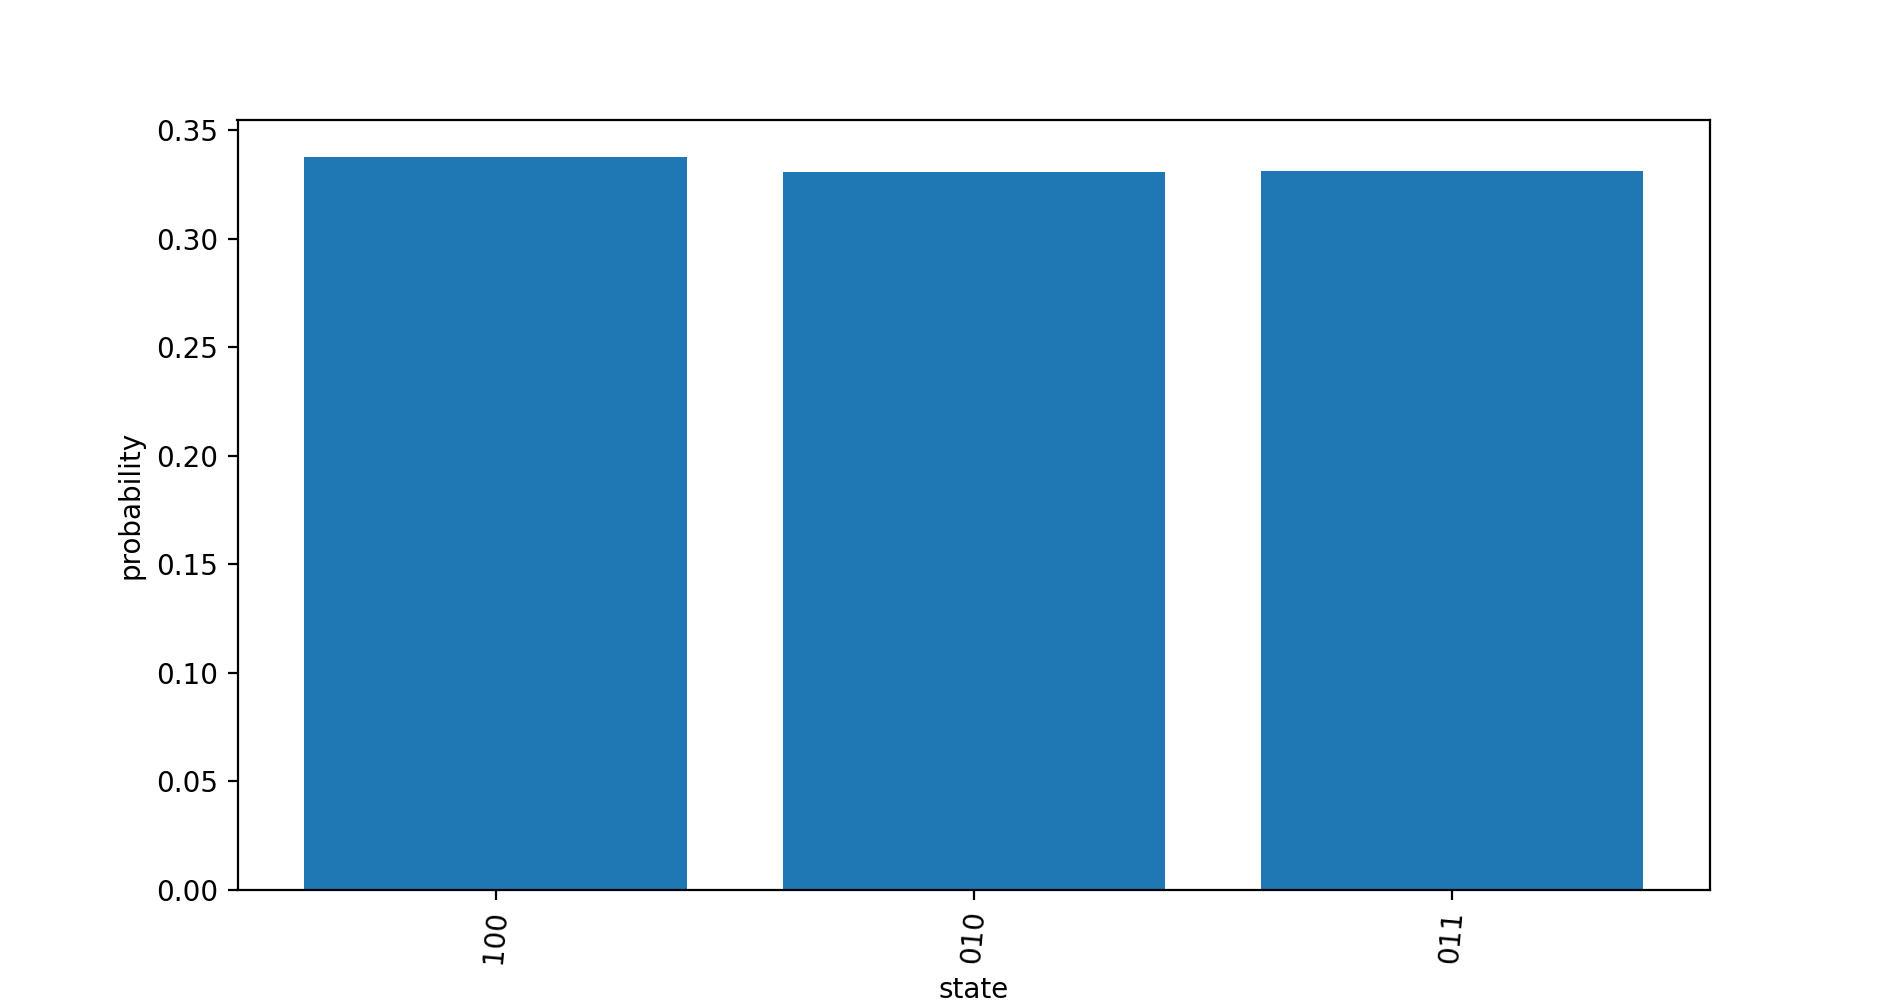

In [13]:
plot_hist(qaoa_example1_with_algorithms, qaoa_example1_with_algorithms.angles_hist["d1_final"], params = params1)

### Interesting cost function with algorithms

In [14]:
H_cost_interesting = np.array([5.0, 2.0, 2.0, 2.5, 2.0, 1.0, 3.0, 0.1])
H_cost_interesting_sympy = pauli_string_to_sympy(np.diag(H_cost_interesting))

display(H_cost_interesting)
display(H_cost_interesting_sympy)

dim= 3.0


array([5. , 2. , 2. , 2.5, 2. , 1. , 3. , 0.1])

c*(2.2*1x1x1 + 0.8*1x1xsigma3 + 0.3*1xsigma3x1 + 0.2*1xsigma3xsigma3 + 0.675*sigma3x1x1 - 0.175*sigma3x1xsigma3 + 0.325*sigma3xsigma3x1 + 0.675*sigma3xsigma3xsigma3)

In [15]:
params3 = {"H_cost_array" : create_circuit_array(H_cost_interesting_sympy),
           "H_mixer_array" : create_circuit_array(H_mixer),
           "H_cost" : H_cost_interesting}

In [16]:
class QAOA_example1_interesting(QAOABase):
    def cost(self, string, params):
        H_cost = params.get("H_cost")
        return H_cost[int(string, 2)]
    
    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        # initial state
        ampl = 1. / np.sqrt(3.)
        ampl_vec = [0., 0., ampl, ampl, ampl, 0., 0., 0.]
        circ.initialize(ampl_vec, q[::-1])
        circ.barrier()
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            create_circuit_from_array(circ, params.get("H_cost_array"), gamma)
            
            # H_mixer
            create_circuit_from_array(circ, params.get("H_mixer_array"), beta)
            
        circ.measure(q, c)
        return circ

display(QAOA_example1_interesting().createCircuit(
    [1.0, 1.0], 1, params = params3).draw())

┌────────────────────────────────────────────────┐ ░  ░ ┌───────────┐»
q22838_0: ┤2                                               ├─░──░─┤ Rz(-1.35) ├»
          │                                                │ ░  ░ └───────────┘»
q22838_1: ┤1 Initialize(0,0,0.57735,0.57735,0.57735,0,0,0) ├─░──░──────────────»
          │                                                │ ░  ░              »
q22838_2: ┤0                                               ├─░──░──────────────»
          └────────────────────────────────────────────────┘ ░  ░              »
  c830: 3/═════════════════════════════════════════════════════════════════════»
                                                                               »
«           ░                                   ░                        ░ »
«q22838_0: ─░───■───────────────────────────■───░────────────────────────░─»
«           ░ ┌─┴─┐                       ┌─┴─┐ ░                        ░ »
«q22838_1: ─░─┤ X ├──■─────────────────■──┤ X ├─░───■────────────────■───░─»
«           ░ └───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘ ░ ┌─┴─┐┌──────────┐┌─┴─┐ ░ »
«q22838_2: ─░──────┤ X ├┤ Rz(-1.35) ├┤ X ├──────░─┤ X ├┤ Rz(-0.4) ├┤ X ├─░─»
«           ░      └───┘└───────────┘└───┘      ░ └───┘└──────────┘└───┘ ░ »
«  c830: 3/════════════════════════════════════════════════════════════════»
«                                                                          »
«                       ░              ░                         ░      »
«q22838_0: ─────────────░──────────────░───■─────────────────■───░───■──»
«                       ░ ┌──────────┐ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░   │  »
«q22838_1: ─────────────░─┤ Rz(-0.6) ├─░─┤ X ├┤ Rz(-0.65) ├┤ X ├─░───┼──»
«          ┌──────────┐ ░ └──────────┘ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐»
«q22838_2: ┤ Rz(-1.6) ├─░──────────────░─────────────────────────░─┤ X ├»
«          └──────────┘ ░              ░                         ░ └───┘»
«  c830: 3/═════════════════════════════════════════════════════════════»
«                                                                       »
«                            ░ ┌───┐                    ┌───┐ ░ ┌───┐          »
«q22838_0: ──────────────■───░─┤ H ├──■──────────────■──┤ H ├─░─┤ H ├──■───────»
«                        │   ░ ├───┤┌─┴─┐┌────────┐┌─┴─┐├───┤ ░ ├───┤┌─┴─┐     »
«q22838_1: ──────────────┼───░─┤ H ├┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├─░─┤ H ├┤ X ├──■──»
«          ┌──────────┐┌─┴─┐ ░ └───┘└───┘└────────┘└───┘└───┘ ░ └───┘└───┘┌─┴─┐»
«q22838_2: ┤ Rz(0.35) ├┤ X ├─░────────────────────────────────░───────────┤ X ├»
«          └──────────┘└───┘ ░                                ░           └───┘»
«  c830: 3/════════════════════════════════════════════════════════════════════»
«                                                                              »
«                              ┌───┐ ░                      ░           »
«q22838_0: ─────────────────■──┤ H ├─░──────────────────────░────────■──»
«                         ┌─┴─┐├───┤ ░                      ░        │  »
«q22838_1: ────────────■──┤ X ├┤ H ├─░──────────────────────░────────┼──»
«          ┌────────┐┌─┴─┐└───┘└───┘ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌─┴─┐»
«q22838_2: ┤ Rz(-1) ├┤ X ├───────────░─┤ H ├┤ Rz(-1) ├┤ H ├─░─┤ H ├┤ X ├»
«          └────────┘└───┘           ░ └───┘└────────┘└───┘ ░ └───┘└───┘»
«  c830: 3/═════════════════════════════════════════════════════════════»
«                                                                       »
«                               ░ ┌───┐                              ┌───┐ ░ »
«q22838_0: ────────────■────────░─┤ H ├──■────────────────────────■──┤ H ├─░─»
«                      │        ░ ├───┤┌─┴─┐                    ┌─┴─┐├───┤ ░ »
«q22838_1: ────────────┼────────░─┤ H ├┤ X ├──■──────────────■──┤ X ├┤ H ├─░─»
«          ┌────────┐┌─┴─┐┌───┐ ░ ├───┤└───┘┌─┴─┐┌────────┐┌─┴─┐├───┤└───┘ ░ »
«q22838_2: ┤ Rz(-1) ├┤ X ├┤ H ├─░─┤ H ├─────┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├──────░─»
«          └────────┘└───┘└───┘ ░ └───┘     └───┘└───

In [17]:
qaoa_example1_interesting = QAOA_example1_interesting()
qaoa_example1_interesting.increase_depth(backend = qasmSim, precision = 0.25, params = params3)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -2.49609375


<IPython.core.display.Javascript object>


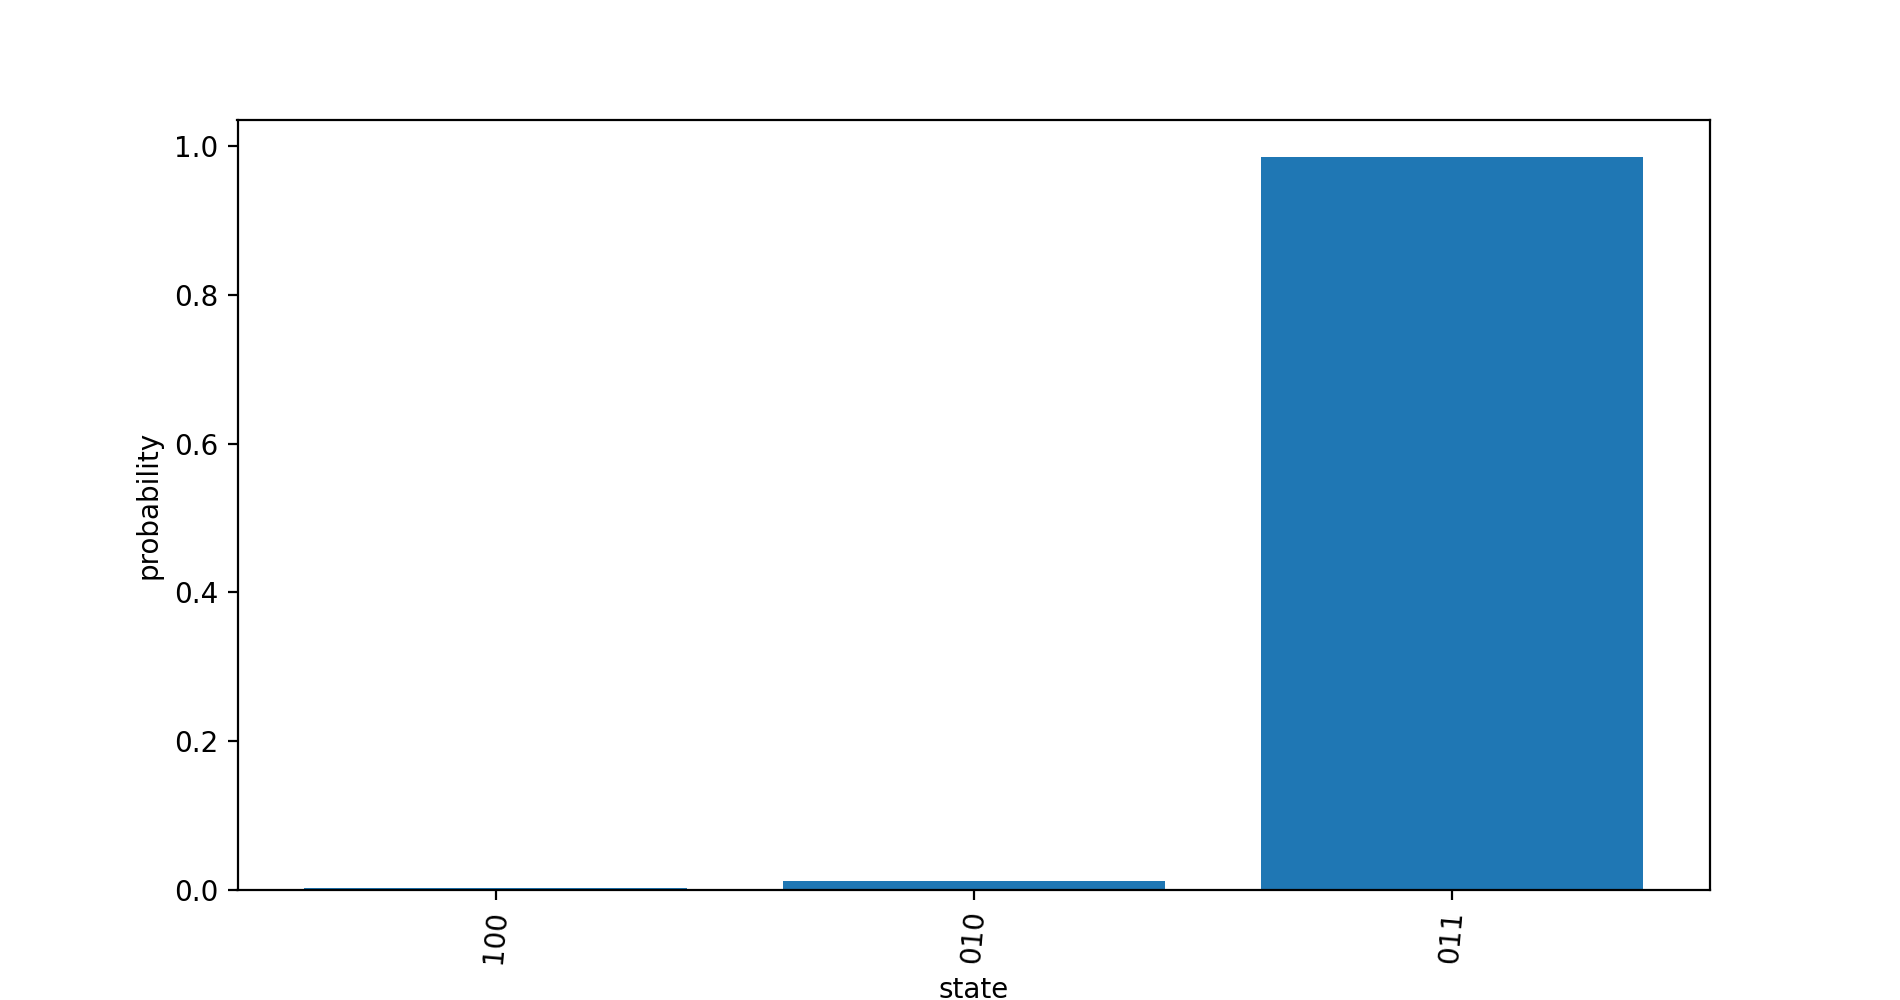

In [18]:
plot_hist(qaoa_example1_interesting, 
          qaoa_example1_interesting.angles_hist["d1_final"], params = params3)

### Interesting cost function with penalty hamiltonian

In [60]:
alpha = -10.0

H_cost_penalty = np.array([5.0, 2.0, 2.0, 2.5, 2.0, 1.0, 3.0, 0.1])
# create penalty hamiltonian
feasible_states = ["".join(i) for i in list(itertools.product("01", repeat = 3))]
constrained_states = ["100", "010", "011"]
g = get_g(constrained_states)

for state in feasible_states:
    if state not in constrained_states:
        expr = g[1]
        for i, symbol in enumerate(g[0]):
            expr = expr.subs(symbol, int(state[i]))
        H_cost_penalty[int(state, 2)] += alpha * expr

print(H_cost_penalty)
H_cost_penalty_sympy = pauli_string_to_sympy(np.diag(H_cost_penalty))

[-15.  -38.    2.    2.5   2.  -59.  -17.  -39.9]
dim= 3.0


In [61]:
params4 = {"H_cost_array" : create_circuit_array(H_cost_penalty_sympy), 
           "H_cost" : H_cost_penalty}

In [62]:
class QAOA_example1_penalty_hamiltonian(QAOABase):
    def cost(self, string, params):
        H_cost = params.get("H_cost")
        return H_cost[int(string, 2)]

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        # initial state
        ampl = 1. / np.sqrt(3.)
        ampl_vec = [0., 0., ampl, ampl, ampl, 0., 0., 0.]
        circ.initialize(ampl_vec, q[::-1])
        circ.barrier()
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            create_circuit_from_array(circ, params.get("H_cost_array"), gamma)
            
            # H_mixer
            circ.rx(-2. * beta, [q[0], q[1], q[2]])
            
        circ.measure(q, c)
        return circ

display(QAOA_example1_penalty_hamiltonian().createCircuit(
    [1.0, 1.0], 1, params = params4).draw())

┌────────────────────────────────────────────────┐ ░ ┌────────────┐»
q34064_0: ┤2                                               ├─░─┤ Rz(-16.35) ├»
          │                                                │ ░ └────────────┘»
q34064_1: ┤1 Initialize(0,0,0.57735,0.57735,0.57735,0,0,0) ├─░───────────────»
          │                                                │ ░               »
q34064_2: ┤0                                               ├─░───────────────»
          └────────────────────────────────────────────────┘ ░               »
 c1262: 3/═══════════════════════════════════════════════════════════════════»
                                                                             »
«           ░               ░                         ░                       »
«q34064_0: ─░───────────────░─────────────────────────░───■───────────────────»
«           ░               ░                         ░ ┌─┴─┐                 »
«q34064_1: ─░───────────────░───■─────────────────■───░─┤ X ├──■──────────────»
«           ░ ┌───────────┐ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘┌─┴─┐┌──────────┐»
«q34064_2: ─░─┤ Rz(-26.6) ├─░─┤ X ├┤ Rz(-15.4) ├┤ X ├─░──────┤ X ├┤ Rz(3.65) ├»
«           ░ └───────────┘ ░ └───┘└───────────┘└───┘ ░      └───┘└──────────┘»
« c1262: 3/═══════════════════════════════════════════════════════════════════»
«                                                                             »
«                     ░                         ░  ░                         ░ »
«q34064_0: ───────■───░───■─────────────────■───░──░───■─────────────────■───░─»
«               ┌─┴─┐ ░   │                 │   ░  ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ »
«q34064_1: ──■──┤ X ├─░───┼─────────────────┼───░──░─┤ X ├┤ Rz(14.35) ├┤ X ├─░─»
«          ┌─┴─┐└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░  ░ └───┘└───────────┘└───┘ ░ »
«q34064_2: ┤ X ├──────░─┤ X ├┤ Rz(15.35) ├┤ X ├─░──░─────────────────────────░─»
«          └───┘      ░ └───┘└───────────┘└───┘ ░  ░                         ░ »
« c1262: 3/════════════════════════════════════════════════════════════════════»
«                                                                              »
«                       ░ ┌────────┐┌─┐      
«q34064_0: ─────────────░─┤ Rx(-2) ├┤M├──────
«          ┌──────────┐ ░ ├────────┤└╥┘┌─┐   
«q34064_1: ┤ Rz(14.4) ├─░─┤ Rx(-2) ├─╫─┤M├───
«          └──────────┘ ░ ├────────┤ ║ └╥┘┌─┐
«q34064_2: ─────────────░─┤ Rx(-2) ├─╫──╫─┤M├
«                       ░ └────────┘ ║  ║ └╥┘
« c1262: 3/══════════════════════════╩══╩══╩═
«                                    0  1  2

In [63]:
qaoa_example1_penalty_hamiltonian = QAOA_example1_penalty_hamiltonian()
qaoa_example1_penalty_hamiltonian.increase_depth(backend = qasmSim, precision = 0.25, params = params4)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -2.16748046875


<IPython.core.display.Javascript object>


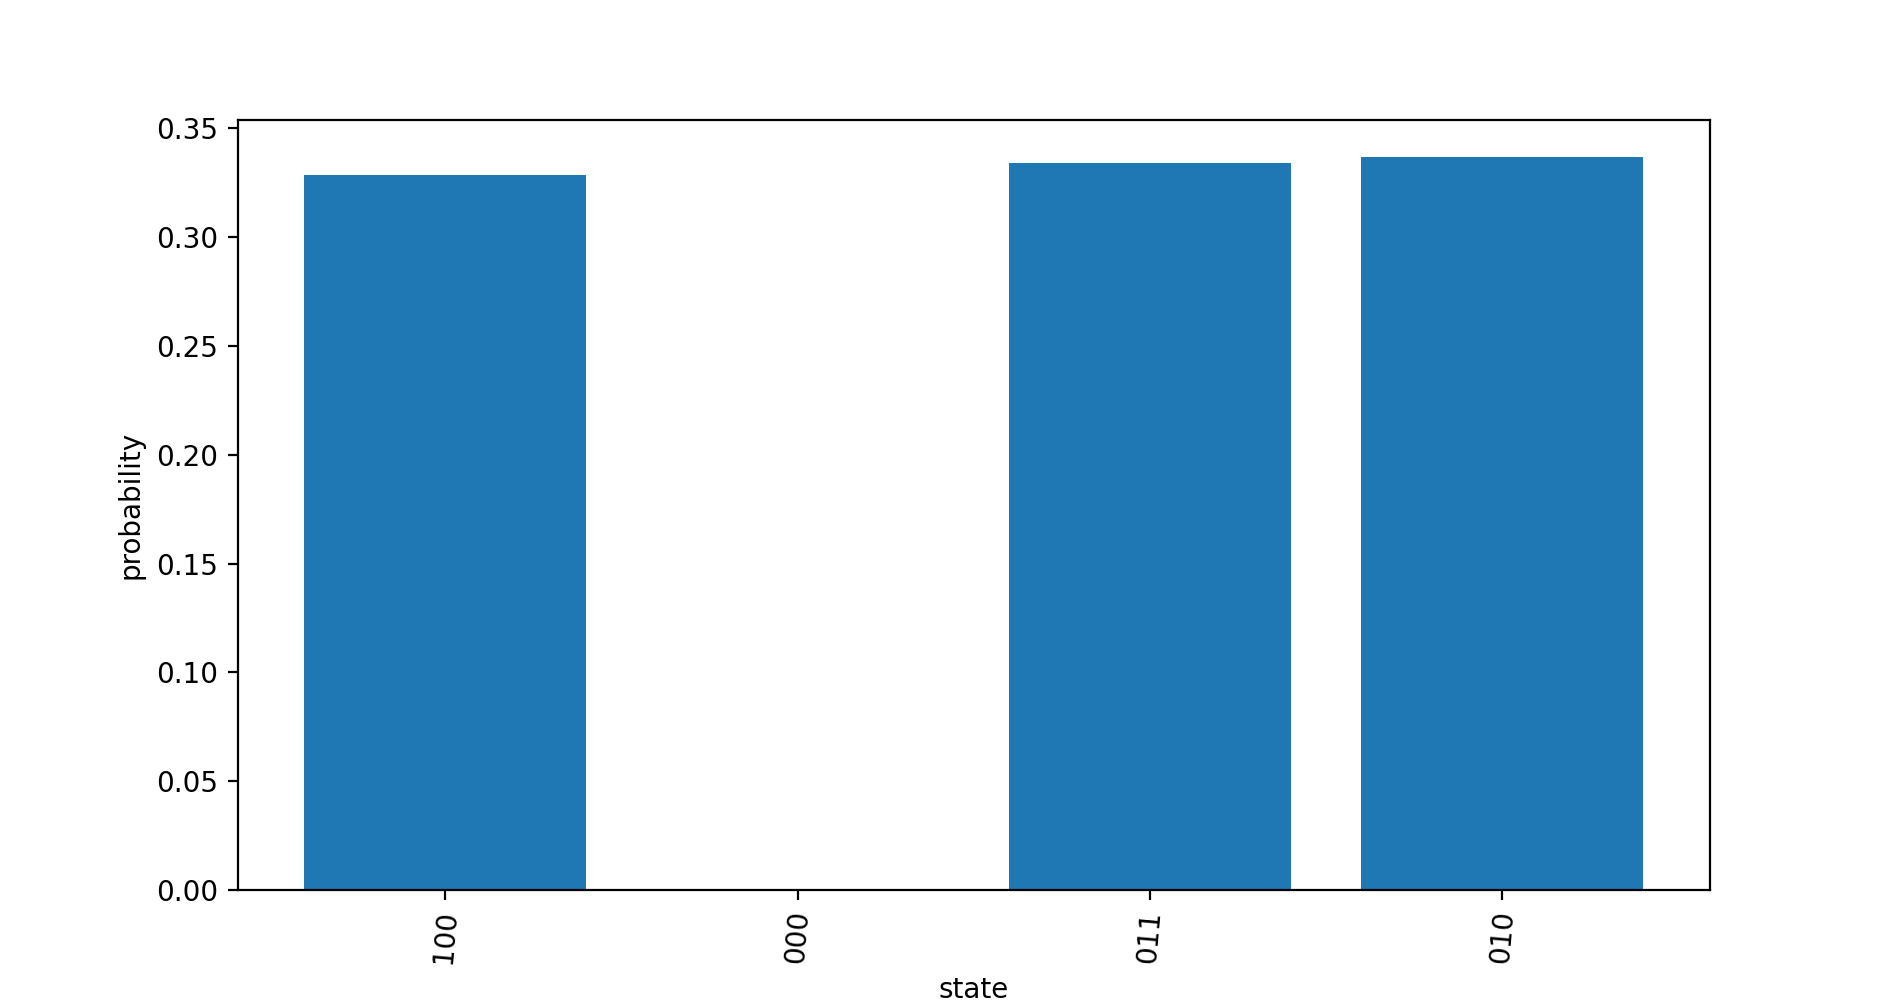

In [64]:
plot_hist(qaoa_example1_penalty_hamiltonian, 
          qaoa_example1_penalty_hamiltonian.angles_hist["d1_final"], params = params4)

## Example 2

Feasible subspace: $ B = \{\ket{10010}, \ket{01110}, \ket{10011}, \ket{11101}, \ket{00110}, \ket{01010}\} $

In [26]:
feasible_states2 = np.array(["10010", "01110", "10011", "11101", "00110", "01010"])

# create H_cost
H_cost2 = 20. * np.ones(2 ** 5)
for feasible_state in feasible_states2:
    H_cost2[int(feasible_state, 2)] = 1.
H_cost2 = pauli_string_to_sympy(np.diag(H_cost2))
display(H_cost2)

dim= 5.0


c*(526.0*1x1x1x1x1 - 38.0*1x1x1x1xsigma3 + 76.0*1x1x1xsigma3x1 + 76.0*1x1x1xsigma3xsigma3 + 38.0*1x1xsigma3xsigma3x1 - 38.0*1x1xsigma3xsigma3xsigma3 + 38.0*1xsigma3x1xsigma3x1 - 38.0*1xsigma3x1xsigma3xsigma3 - 38.0*1xsigma3xsigma3x1x1 + 38.0*1xsigma3xsigma3x1xsigma3 - 76.0*sigma3x1x1x1xsigma3 + 38.0*sigma3x1x1xsigma3x1 + 38.0*sigma3x1x1xsigma3xsigma3 + 38.0*sigma3x1xsigma3x1x1 + 38.0*sigma3x1xsigma3x1xsigma3 - 76.0*sigma3x1xsigma3xsigma3x1 + 38.0*sigma3xsigma3x1x1x1 + 38.0*sigma3xsigma3x1x1xsigma3 - 76.0*sigma3xsigma3x1xsigma3x1 + 76.0*sigma3xsigma3xsigma3x1x1 - 38.0*sigma3xsigma3xsigma3xsigma3x1 - 38.0*sigma3xsigma3xsigma3xsigma3xsigma3)

In [27]:
# create H_mixer
table2 = {
    (1, 2) : ["01100", "10000"],
    (1, 3) : ["00010", "00011"],
    (1, 4) : ["00010", "01101"],
    (1, 5) : ["00100", "10000"],
    (1, 6) : ["01000", "10000"],
    (2, 3) : ["01100", "10001"],
    (2, 4) : ["00010", "10001"],
    (2, 5) : ["00100", "01100"],
    (2, 6) : ["01000", "01100"],
    (3, 4) : ["00011", "01101"],
    (3, 5) : ["00100", "10001"],
    (3, 6) : ["01000", "10001"],
    (4, 5) : ["00010", "11001"],
    (4, 6) : ["00010", "10101"],
    (5, 6) : ["00100", "01000"]}

H_mixer2 = 0
T_c2 = get_T(2, "nearest_int")
for index, (key, mix_states) in enumerate(table2.items()):
    T_ij = get_T(len(feasible_states2), "leftright", i = key[0] - 1, j = key[1] - 1)
    H_b_ij = get_Pauli_string_with_algorithm3(feasible_states2, T_ij)
    H_c_ij = get_Pauli_string_with_algorithm3(mix_states, T_c2)
    a = symbols(f"a{index}")
    H_mixer2 += a * simplifyH(H_b_ij + H_c_ij)

display(H_mixer2)

a0*(0.125*sigma1xsigma1xsigma1x1x1 + 0.125*sigma1xsigma1xsigma1x1xsigma3 - 0.125*sigma1xsigma2xsigma2x1x1 - 0.125*sigma1xsigma2xsigma2x1xsigma3 + 0.125*sigma2xsigma1xsigma2x1x1 + 0.125*sigma2xsigma1xsigma2x1xsigma3 + 0.125*sigma2xsigma2xsigma1x1x1 + 0.125*sigma2xsigma2xsigma1x1xsigma3) + a1*(0.125*1x1x1x1xsigma1 - 0.125*1x1x1xsigma3xsigma1 + 0.125*1x1xsigma3x1xsigma1 - 0.125*1x1xsigma3xsigma3xsigma1 + 0.125*1xsigma3x1x1xsigma1 - 0.125*1xsigma3x1xsigma3xsigma1 + 0.125*1xsigma3xsigma3x1xsigma1 - 0.125*1xsigma3xsigma3xsigma3xsigma1) + a10*(0.125*sigma1x1xsigma1x1xsigma1 + 0.125*sigma1x1xsigma2x1xsigma2 + 0.125*sigma1xsigma3xsigma1x1xsigma1 + 0.125*sigma1xsigma3xsigma2x1xsigma2 - 0.125*sigma2x1xsigma1x1xsigma2 + 0.125*sigma2x1xsigma2x1xsigma1 - 0.125*sigma2xsigma3xsigma1x1xsigma2 + 0.125*sigma2xsigma3xsigma2x1xsigma1) + a11*(0.125*sigma1xsigma1x1x1xsigma1 + 0.125*sigma1xsigma1xsigma3x1xsigma1 + 0.125*sigma1xsigma2x1x1xsigma2 + 0.125*sigma1xsigma2xsigma3x1xsigma2 - 0.125*sigma2xsigma1x1x1xs

In [28]:
params2 = {"H_mixer_array" : create_circuit_array(H_mixer2),
           "H_cost_array" : create_circuit_array(H_cost2)}

In [29]:
class QAOA_example2(QAOABase):
    def cost(self, string, params):
        if string in ["10010", "01110", "10011", "11101", "00110", "01010"]:
            return 1.
        return 20.

    def createCircuit(self, angles, depth, params={}):  
        q = QuantumRegister(5)
        c = ClassicalRegister(5)
        circ = QuantumCircuit(q, c)
        
        # initial state
        ampl_vec = np.zeros(32)
        indices = [6, 10, 14, 18, 19, 29]
        for index in indices:
            ampl_vec[index] = 1 / np.sqrt(6)
        circ.initialize(ampl_vec, q[::-1])
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            create_circuit_from_array(circ, params.get("H_cost_array"), gamma)
            
            # H_mixer
            create_circuit_from_array(circ, params.get("H_mixer_array"), beta)
            
        circ.measure(q, c)
        return circ

display(QAOA_example2().createCircuit(
    [1.0, 1.0], 1, params = params2).draw())

»
q39993_0: »
          »
q39993_1: »
          »
q39993_2: »
          »
q39993_3: »
          »
q39993_4: »
          »
 c1689: 5/»
          »
«          ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q39993_0: ┤4                                                                                                                 ├»
«          │                                                                                                                  │»
«q39993_1: ┤3                                                                                                                 ├»
«          │                                                                                                                  │»
«q39993_2: ┤2 Initialize(0,0,0,0,0,0,0.40825,0,0,0,0.40825,0,0,0,0.40825,0,0,0,0.40825,0.40825,0,0,0,0,0,0,0,0,0,0.40825,0,0) ├»
«          │                                                                                                                  │»
«q39993_3: ┤1                                                                                                                 ├»
«          │                                                                                                                  │»
«q39993_4: ┤0                                                                                                                 ├»
«          └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
« c1689: 5/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                              »
«                                ░                       ░           »
«q39993_0: ──────────────────────░───────────────────────░───────────»
«                                ░                       ░           »
«q39993_1: ──────────────────────░───■───────────────■───░───■───────»
«                                ░   │               │   ░ ┌─┴─┐     »
«q39993_2: ──■───────────────■───░───┼───────────────┼───░─┤ X ├──■──»
«          ┌─┴─┐┌─────────┐┌─┴─┐ ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░ └───┘  │  »
«q39993_3: ┤ X ├┤ Rz(-76) ├┤ X ├─░─┤ X ├┤ Rz(-76) ├┤ X ├─░────────┼──»
«          └───┘└─────────┘└───┘ ░ └───┘└─────────┘└───┘ ░      ┌─┴─┐»
«q39993_4: ──────────────────────░───────────────────────░──────┤ X ├»
«                                ░                       ░      └───┘»
« c1689: 5/══════════════════════════════════════════════════════════»
«                                                                    »
«                                ░                       ░           »
«q39993_0: ──────────────────────░───■───────────────■───░───■───────»
«                                ░   │               │   ░   │       »
«q39993_1: ──────────────────■───░───┼───────────────┼───░───┼───────»
«                          ┌─┴─┐ ░   │               │   ░   │       »
«q39993_2: ─────────────■──┤ X ├─░───┼───────────────┼───░───┼───────»
«                       │  └───┘ ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░ ┌─┴─┐     »
«q39993_3: ─────────────┼────────░─┤ X ├┤ Rz(-76) ├┤ X ├─░─┤ X ├──■──»
«          ┌─────────┐┌─┴─┐      ░ └───┘└─────────┘└───┘ ░ └───┘┌─┴─┐»
«q39993_4: ┤ Rz(-76) ├┤ X ├──────░───────────────────────░──────┤ X ├»
«          └─────────┘└───┘      ░                       ░      └───┘»
« c1689: 5/══════════════════════════════════════════════════════════»
«                                                                    »
«                                ░                       ░           »
«q39993_0: ──────────────────■───░───■───────────────■───░───■───────»
«                            │   ░   │               │   ░   │       »
«q39993_1: ──────────────────┼───░───┼───────────────┼───░───┼───────»
«                            │   ░ ┌─┴─┐┌──────

In [30]:
start = time.time()
qaoa_example2 = QAOA_example2()
qaoa_example2.increase_depth(backend = qasmSim, precision = 5.0, params = params2)
print(f"time:{time.time() - start}")

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -1.0
time:1825.2769968509674


<IPython.core.display.Javascript object>


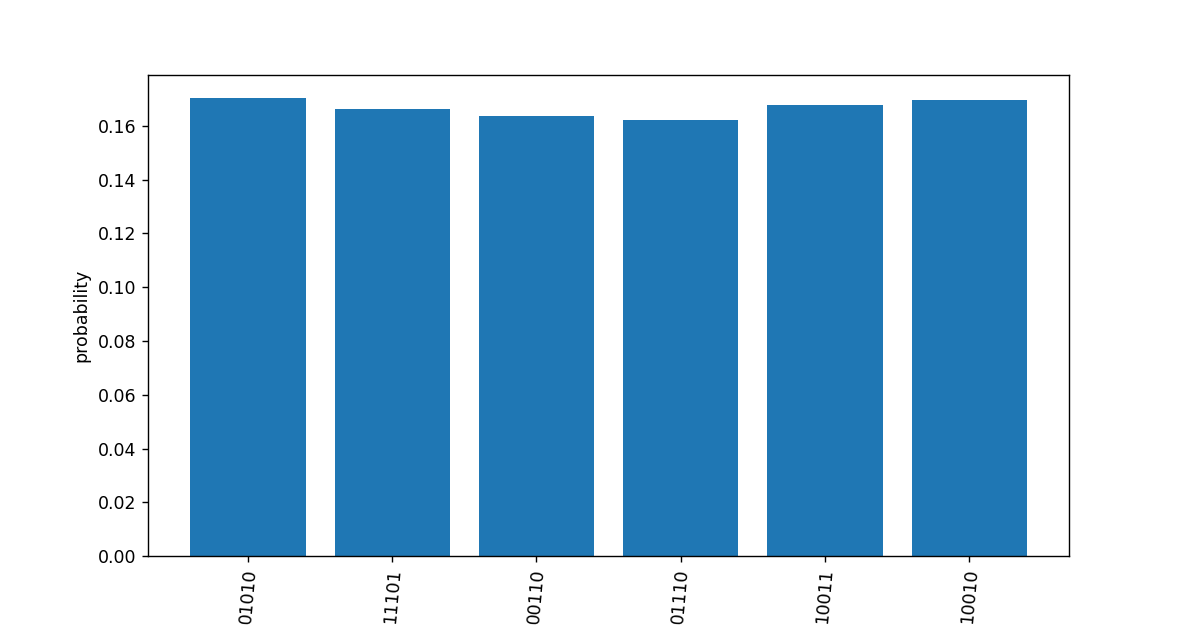

In [31]:
plot_hist(qaoa_example2, qaoa_example2.angles_hist["d1_final"], params = params2)